# GAN Mouse Pathing
#### Garrett Lappe - garrett.l.lappe@gmail.com
#### MSDS - Data Science Practicum

In [1]:
import pandas as pd
import numpy as np

from glob import glob
import os

from PIL import Image
from matplotlib import pyplot as plt
import cv2

from scipy import misc, ndimage

In [2]:
files = glob('data\\imgs\\*.jpg')

In [3]:
len(files)

52153

In [4]:
files[:10]

['data\\imgs\\path_0_Garrett.jpg',
 'data\\imgs\\path_10000_Jennifer.jpg',
 'data\\imgs\\path_10001_Jennifer.jpg',
 'data\\imgs\\path_10002_Jennifer.jpg',
 'data\\imgs\\path_10003_Jennifer.jpg',
 'data\\imgs\\path_10004_Jennifer.jpg',
 'data\\imgs\\path_10005_Jennifer.jpg',
 'data\\imgs\\path_10006_Jennifer.jpg',
 'data\\imgs\\path_10007_Jennifer.jpg',
 'data\\imgs\\path_10008_Jennifer.jpg']

In [5]:
df = pd.DataFrame()

In [6]:
df['img_path'] = files

In [7]:
df.head()

,img_path
0,data\imgs\path_0_Garrett.jpg
1,data\imgs\path_10000_Jennifer.jpg
2,data\imgs\path_10001_Jennifer.jpg
3,data\imgs\path_10002_Jennifer.jpg
4,data\imgs\path_10003_Jennifer.jpg


In [8]:
df['user'] = df['img_path'].apply(lambda x: x[x.rindex('_')+1:len(x)-4])
df.head()

,img_path,user
0,data\imgs\path_0_Garrett.jpg,Garrett
1,data\imgs\path_10000_Jennifer.jpg,Jennifer
2,data\imgs\path_10001_Jennifer.jpg,Jennifer
3,data\imgs\path_10002_Jennifer.jpg,Jennifer
4,data\imgs\path_10003_Jennifer.jpg,Jennifer


In [9]:
df['path_id'] = df['img_path'].apply(lambda x: x[x.index('_')+1:x.rindex('_')])
df.head()

,img_path,user,path_id
0,data\imgs\path_0_Garrett.jpg,Garrett,0
1,data\imgs\path_10000_Jennifer.jpg,Jennifer,10000
2,data\imgs\path_10001_Jennifer.jpg,Jennifer,10001
3,data\imgs\path_10002_Jennifer.jpg,Jennifer,10002
4,data\imgs\path_10003_Jennifer.jpg,Jennifer,10003


In [10]:
df.dtypes

img_path    object
user        object
path_id     object
dtype: object

In [11]:
import gc

In [12]:
gc.collect()

107

In [13]:
def load_threshold_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (100, 50), cv2.INTER_NEAREST)
    ret, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)  # very harsh threshold -- any non-white -> black pixel
    img_array = np.array(img)
    #img_array = np.uint8(img_array/255)
    return img_array

In [14]:
p = 'data\imgs\path_10000_Jennifer.jpg'
img = load_threshold_img(p)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

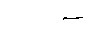

In [15]:
Image.fromarray(img)

### Small change: limit pixel value range between 0 and 1 for the model

In [16]:
def load_threshold_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (100, 50), cv2.INTER_NEAREST)
    ret, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)  # very harsh threshold -- any non-white -> black pixel
    img_array = np.array(img)
    img_array = np.uint8(img_array/255)
    return img_array

In [17]:
df['img'] = df['img_path'].apply(load_threshold_img)

In [18]:
df.head()

,img_path,user,path_id,img
0,data\imgs\path_0_Garrett.jpg,Garrett,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,data\imgs\path_10000_Jennifer.jpg,Jennifer,10000,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
2,data\imgs\path_10001_Jennifer.jpg,Jennifer,10001,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,data\imgs\path_10002_Jennifer.jpg,Jennifer,10002,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,data\imgs\path_10003_Jennifer.jpg,Jennifer,10003,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


In [19]:
gc.collect()

20

In [20]:
df.loc[0, 'img'].shape

(50, 100)

In [21]:
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, ZeroPadding2D
from tensorflow.keras.models import Model

from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential

In [22]:
from tensorflow.keras.activations import relu

In [23]:
img_shape = df.loc[0, 'img'].shape
img_shape

(50, 100)

In [24]:
rows, cols = img_shape
channels = 1  # grayscale = 1, bgr / rgb = 3

shape = (rows, cols, channels)
shape

(50, 100, 1)

In [25]:
X = np.array(df['img'].values)

In [26]:
X = np.array([np.array(img) for img in X])

In [27]:
X = np.expand_dims(X, -1)

In [28]:
X.shape

(52153, 50, 100, 1)

In [29]:
from tensorflow.keras import backend as K

### GAN definition

In [303]:
clear_session()
class MousePathGAN():
    def __init__(self):
        self.img_rows = 50
        self.img_cols = 100
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.latent_dim = 100
        
        optimizer = Adam(0.0001, 0.1)
        # optimizer = 'adam'
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)  # classify the fake img
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):
        model = Sequential()

        model.add(Dense(50*100*1, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((50, 100, 1)))
        model.add(Conv2D(12, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(4, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        #model.add(Conv2D(4, kernel_size=3, padding="same"))
        #model.add(BatchNormalization())
        #model.add(Activation("relu"))
        #model.add(Conv2D(4, kernel_size=3, padding="same"))
        #model.add(BatchNormalization())
        #model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("tanh"))

        print('GENERATOR')
        print('Input shape:', self.latent_dim)
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(8, kernel_size=3, input_shape=self.img_shape, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(8, kernel_size=3, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.95))
        model.add(Activation("relu"))
        model.add(Conv2D(8, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.95))
        model.add(Activation("relu"))
        model.add(Conv2D(8, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.95))
        model.add(Activation("relu"))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        print('DISCRIMINATOR')
        print('Input shape:', img_shape)
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def get_threshold_img(self, gen_img):
        gen_img = gen_img * 255
        
        ret, img = cv2.threshold(gen_img, 1, 255, cv2.THRESH_BINARY)  # very harsh threshold -- any non-white -> black pixel
        img_array = np.array(img)
        
        img_array = np.expand_dims(img_array, -1)
        
        #img_array = img_array.reshape((1, 50, 100, 1))
        return img_array
    
    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = X
        print('X_train shape:', X_train.shape)


        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            gen_imgs = np.array([self.get_threshold_img(g_img) for g_img in gen_imgs])


            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

                
    def save_imgs(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        print(gen_imgs[0])
        # Rescale images
        #gen_imgs = 0.5 * gen_imgs + 0.5
        
        gen_imgs = np.array([self.get_threshold_img(gen_img) for gen_img in gen_imgs])

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("data/generated/path_%d.png" % epoch)
        plt.close()

        
gan = MousePathGAN()

DISCRIMINATOR
Input shape: (50, 100)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 100, 8)        80        
_________________________________________________________________
activation (Activation)      (None, 50, 100, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 100, 8)        584       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 51, 101, 8)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 51, 101, 8)        32        
_________________________________________________________________
activation_1 (Activation)    (None, 51, 101, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)  

In [304]:
gc.collect()

206514

In [305]:
gan.train(epochs=50000, batch_size=2, save_interval=100)

X_train shape: (52153, 50, 100, 1)
0 [D loss: 1.215265, acc.: 50.00%] [G loss: 0.727919]
[[[ 0.00025588]
  [ 0.0007617 ]
  [-0.00773939]
  ...
  [-0.00163852]
  [ 0.01006053]
  [ 0.00910735]]

 [[-0.00241256]
  [-0.00392103]
  [-0.0083947 ]
  ...
  [ 0.00843751]
  [ 0.02210529]
  [ 0.01887649]]

 [[ 0.00554868]
  [ 0.01367358]
  [ 0.00012744]
  ...
  [ 0.01917583]
  [ 0.0458033 ]
  [ 0.01155503]]

 ...

 [[-0.00386917]
  [ 0.03126585]
  [ 0.05080916]
  ...
  [ 0.03150599]
  [ 0.02321679]
  [ 0.02538209]]

 [[ 0.01095153]
  [ 0.05356419]
  [ 0.04042678]
  ...
  [ 0.05343612]
  [ 0.02881392]
  [ 0.00610703]]

 [[ 0.00132166]
  [ 0.0308971 ]
  [ 0.02730754]
  ...
  [ 0.01359878]
  [ 0.01012102]
  [ 0.02505683]]]
1 [D loss: 0.680967, acc.: 50.00%] [G loss: 0.923339]
2 [D loss: 0.348752, acc.: 100.00%] [G loss: 1.108229]
3 [D loss: 0.109578, acc.: 100.00%] [G loss: 1.130256]
4 [D loss: 0.083389, acc.: 100.00%] [G loss: 1.109506]
5 [D loss: 0.066139, acc.: 100.00%] [G loss: 1.085182]
6 [D lo

128 [D loss: 0.001798, acc.: 100.00%] [G loss: 3.787220]
129 [D loss: 0.000183, acc.: 100.00%] [G loss: 3.839506]
130 [D loss: 0.000279, acc.: 100.00%] [G loss: 3.815092]
131 [D loss: 0.001412, acc.: 100.00%] [G loss: 3.860221]
132 [D loss: 0.000326, acc.: 100.00%] [G loss: 3.860605]
133 [D loss: 0.000131, acc.: 100.00%] [G loss: 3.871491]
134 [D loss: 0.000202, acc.: 100.00%] [G loss: 3.920363]
135 [D loss: 0.001667, acc.: 100.00%] [G loss: 3.932206]
136 [D loss: 0.000373, acc.: 100.00%] [G loss: 3.972391]
137 [D loss: 0.000177, acc.: 100.00%] [G loss: 3.929375]
138 [D loss: 0.000176, acc.: 100.00%] [G loss: 4.007370]
139 [D loss: 0.000135, acc.: 100.00%] [G loss: 4.083447]
140 [D loss: 0.001761, acc.: 100.00%] [G loss: 4.013240]
141 [D loss: 0.000232, acc.: 100.00%] [G loss: 4.055328]
142 [D loss: 0.000085, acc.: 100.00%] [G loss: 4.062747]
143 [D loss: 0.000158, acc.: 100.00%] [G loss: 3.995350]
144 [D loss: 0.000386, acc.: 100.00%] [G loss: 4.090196]
145 [D loss: 0.000282, acc.: 10

262 [D loss: 0.000040, acc.: 100.00%] [G loss: 4.420502]
263 [D loss: 0.000179, acc.: 100.00%] [G loss: 4.401505]
264 [D loss: 0.000036, acc.: 100.00%] [G loss: 4.406304]
265 [D loss: 0.000024, acc.: 100.00%] [G loss: 4.408289]
266 [D loss: 0.000026, acc.: 100.00%] [G loss: 4.376614]
267 [D loss: 0.000078, acc.: 100.00%] [G loss: 4.405519]
268 [D loss: 0.000094, acc.: 100.00%] [G loss: 4.400614]
269 [D loss: 0.000311, acc.: 100.00%] [G loss: 4.384201]
270 [D loss: 0.000039, acc.: 100.00%] [G loss: 4.364533]
271 [D loss: 0.000088, acc.: 100.00%] [G loss: 4.389098]
272 [D loss: 0.000112, acc.: 100.00%] [G loss: 4.385431]
273 [D loss: 0.000068, acc.: 100.00%] [G loss: 4.374782]
274 [D loss: 0.000120, acc.: 100.00%] [G loss: 4.388917]
275 [D loss: 0.000173, acc.: 100.00%] [G loss: 4.363624]
276 [D loss: 0.000226, acc.: 100.00%] [G loss: 4.383709]
277 [D loss: 0.000043, acc.: 100.00%] [G loss: 4.360116]
278 [D loss: 0.000018, acc.: 100.00%] [G loss: 4.359218]
279 [D loss: 0.000097, acc.: 10

397 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.719093]
398 [D loss: 0.000035, acc.: 100.00%] [G loss: 3.731342]
399 [D loss: 0.000077, acc.: 100.00%] [G loss: 3.741534]
400 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.719930]
[[[-0.81503725]
  [-0.4755303 ]
  [-0.48175147]
  ...
  [-0.4972495 ]
  [-0.45620465]
  [-0.29708165]]

 [[-0.9030464 ]
  [-0.3576363 ]
  [-0.3371441 ]
  ...
  [-0.6056801 ]
  [-0.5265176 ]
  [-0.75438136]]

 [[-0.49192452]
  [-0.27591032]
  [-0.689909  ]
  ...
  [ 0.3819026 ]
  [-0.779733  ]
  [ 0.04674721]]

 ...

 [[-0.86645377]
  [ 0.14322037]
  [-0.4966145 ]
  ...
  [-0.63841736]
  [-0.69629556]
  [-0.14824685]]

 [[-0.72193855]
  [-0.06150733]
  [-0.26614186]
  ...
  [-0.19045363]
  [-0.48115745]
  [-0.4325406 ]]

 [[-0.55029917]
  [-0.5006468 ]
  [-0.60233426]
  ...
  [-0.28545544]
  [-0.56377876]
  [-0.3958565 ]]]
401 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.702417]
402 [D loss: 0.000104, acc.: 100.00%] [G loss: 3.735946]
403 [D loss: 0.000018, acc.:

522 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.334671]
523 [D loss: 0.000036, acc.: 100.00%] [G loss: 3.326841]
524 [D loss: 0.000022, acc.: 100.00%] [G loss: 3.317326]
525 [D loss: 0.000016, acc.: 100.00%] [G loss: 3.309861]
526 [D loss: 0.000025, acc.: 100.00%] [G loss: 3.287345]
527 [D loss: 0.000024, acc.: 100.00%] [G loss: 3.302042]
528 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.288261]
529 [D loss: 0.000019, acc.: 100.00%] [G loss: 3.287725]
530 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.272947]
531 [D loss: 0.000017, acc.: 100.00%] [G loss: 3.279075]
532 [D loss: 0.000032, acc.: 100.00%] [G loss: 3.267601]
533 [D loss: 0.000015, acc.: 100.00%] [G loss: 3.255790]
534 [D loss: 0.000027, acc.: 100.00%] [G loss: 3.272650]
535 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.251596]
536 [D loss: 0.000032, acc.: 100.00%] [G loss: 3.268721]
537 [D loss: 0.000069, acc.: 100.00%] [G loss: 3.275481]
538 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.275587]
539 [D loss: 0.000007, acc.: 10

658 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.204480]
659 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.200030]
660 [D loss: 0.000058, acc.: 100.00%] [G loss: 3.195338]
661 [D loss: 0.000146, acc.: 100.00%] [G loss: 3.200634]
662 [D loss: 0.000063, acc.: 100.00%] [G loss: 3.212523]
663 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.222265]
664 [D loss: 0.000023, acc.: 100.00%] [G loss: 3.210652]
665 [D loss: 0.000043, acc.: 100.00%] [G loss: 3.214430]
666 [D loss: 0.000086, acc.: 100.00%] [G loss: 3.208889]
667 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.213501]
668 [D loss: 0.000065, acc.: 100.00%] [G loss: 3.209286]
669 [D loss: 0.000027, acc.: 100.00%] [G loss: 3.192136]
670 [D loss: 0.000019, acc.: 100.00%] [G loss: 3.195311]
671 [D loss: 0.000016, acc.: 100.00%] [G loss: 3.187983]
672 [D loss: 0.000134, acc.: 100.00%] [G loss: 3.190061]
673 [D loss: 0.000033, acc.: 100.00%] [G loss: 3.216706]
674 [D loss: 0.000030, acc.: 100.00%] [G loss: 3.200232]
675 [D loss: 0.000018, acc.: 10

794 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.156358]
795 [D loss: 0.000012, acc.: 100.00%] [G loss: 3.157891]
796 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.156502]
797 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.151485]
798 [D loss: 0.000039, acc.: 100.00%] [G loss: 3.162773]
799 [D loss: 0.000028, acc.: 100.00%] [G loss: 3.148334]
800 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.155560]
[[[-0.14688358]
  [-0.73596025]
  [-0.7489184 ]
  ...
  [-0.32392952]
  [-0.5849371 ]
  [-0.63373077]]

 [[ 0.49766058]
  [-0.6425408 ]
  [-0.6809534 ]
  ...
  [ 0.6937896 ]
  [-0.9129556 ]
  [-0.34902516]]

 [[ 0.22692114]
  [ 0.97998494]
  [-0.7625967 ]
  ...
  [-0.5062378 ]
  [ 0.372636  ]
  [-0.5384592 ]]

 ...

 [[ 0.61785877]
  [-0.2583454 ]
  [-0.57202023]
  ...
  [-0.84618104]
  [-0.3495567 ]
  [-0.21863772]]

 [[-0.93108195]
  [ 0.8268447 ]
  [-0.5419325 ]
  ...
  [ 0.34060365]
  [-0.43654695]
  [-0.83336437]]

 [[-0.8890758 ]
  [-0.03476597]
  [-0.48670948]
  ...
  [-0.48788512]
  [-0

916 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.157543]
917 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.155945]
918 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.152984]
919 [D loss: 0.000017, acc.: 100.00%] [G loss: 3.155576]
920 [D loss: 0.000019, acc.: 100.00%] [G loss: 3.178913]
921 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.159878]
922 [D loss: 0.000037, acc.: 100.00%] [G loss: 3.165024]
923 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.145044]
924 [D loss: 0.000020, acc.: 100.00%] [G loss: 3.162171]
925 [D loss: 0.000025, acc.: 100.00%] [G loss: 3.145928]
926 [D loss: 0.000012, acc.: 100.00%] [G loss: 3.165125]
927 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.160962]
928 [D loss: 0.000014, acc.: 100.00%] [G loss: 3.153174]
929 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.138626]
930 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.144153]
931 [D loss: 0.000019, acc.: 100.00%] [G loss: 3.151272]
932 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.144731]
933 [D loss: 0.000049, acc.: 10

1049 [D loss: 0.000033, acc.: 100.00%] [G loss: 3.153648]
1050 [D loss: 0.000014, acc.: 100.00%] [G loss: 3.151046]
1051 [D loss: 0.000031, acc.: 100.00%] [G loss: 3.162477]
1052 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.152202]
1053 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.163572]
1054 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.161775]
1055 [D loss: 0.000018, acc.: 100.00%] [G loss: 3.145934]
1056 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.159358]
1057 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.166299]
1058 [D loss: 0.000020, acc.: 100.00%] [G loss: 3.161280]
1059 [D loss: 0.000026, acc.: 100.00%] [G loss: 3.155597]
1060 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.171045]
1061 [D loss: 0.000022, acc.: 100.00%] [G loss: 3.169100]
1062 [D loss: 0.000015, acc.: 100.00%] [G loss: 3.170015]
1063 [D loss: 0.000015, acc.: 100.00%] [G loss: 3.159754]
1064 [D loss: 0.000040, acc.: 100.00%] [G loss: 3.184081]
1065 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.164266]
1066 [D loss: 

1183 [D loss: 0.000044, acc.: 100.00%] [G loss: 3.180812]
1184 [D loss: 0.000018, acc.: 100.00%] [G loss: 3.169158]
1185 [D loss: 0.000017, acc.: 100.00%] [G loss: 3.183761]
1186 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.176032]
1187 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.158469]
1188 [D loss: 0.000014, acc.: 100.00%] [G loss: 3.173127]
1189 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.155180]
1190 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.176472]
1191 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.170912]
1192 [D loss: 0.000019, acc.: 100.00%] [G loss: 3.175733]
1193 [D loss: 0.000014, acc.: 100.00%] [G loss: 3.179038]
1194 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.169150]
1195 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.176657]
1196 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.167656]
1197 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.166857]
1198 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.159703]
1199 [D loss: 0.000030, acc.: 100.00%] [G loss: 3.178270]
1200 [D loss: 

1303 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.170893]
1304 [D loss: 0.000021, acc.: 100.00%] [G loss: 3.168294]
1305 [D loss: 0.000016, acc.: 100.00%] [G loss: 3.174264]
1306 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.187380]
1307 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.185984]
1308 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.189619]
1309 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.184254]
1310 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.203892]
1311 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.191617]
1312 [D loss: 0.000031, acc.: 100.00%] [G loss: 3.174632]
1313 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.197325]
1314 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.194339]
1315 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.178701]
1316 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.180331]
1317 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.166566]
1318 [D loss: 0.000016, acc.: 100.00%] [G loss: 3.204677]
1319 [D loss: 0.000018, acc.: 100.00%] [G loss: 3.194153]
1320 [D loss: 

1438 [D loss: 0.000048, acc.: 100.00%] [G loss: 3.171854]
1439 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.186837]
1440 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.200792]
1441 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.183591]
1442 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.192556]
1443 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.163156]
1444 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.167058]
1445 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.181360]
1446 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.174384]
1447 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.181627]
1448 [D loss: 0.000015, acc.: 100.00%] [G loss: 3.190741]
1449 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.157157]
1450 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.187001]
1451 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.171163]
1452 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.193844]
1453 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.174951]
1454 [D loss: 0.000012, acc.: 100.00%] [G loss: 3.175613]
1455 [D loss: 

1571 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.180026]
1572 [D loss: 0.000012, acc.: 100.00%] [G loss: 3.175137]
1573 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.167732]
1574 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.143066]
1575 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.173154]
1576 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.143525]
1577 [D loss: 0.000013, acc.: 100.00%] [G loss: 3.167571]
1578 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.175671]
1579 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.148729]
1580 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.169857]
1581 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.166973]
1582 [D loss: 0.000017, acc.: 100.00%] [G loss: 3.148370]
1583 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.164783]
1584 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.163547]
1585 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.168794]
1586 [D loss: 0.000054, acc.: 100.00%] [G loss: 3.190644]
1587 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.164787]
1588 [D loss: 

1701 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.154654]
1702 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.180045]
1703 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.156584]
1704 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.150705]
1705 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.154812]
1706 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.156584]
1707 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.168292]
1708 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.155333]
1709 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.170120]
1710 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.171084]
1711 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.156172]
1712 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.171919]
1713 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.153231]
1714 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.138595]
1715 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.176682]
1716 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.166600]
1717 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.168540]
1718 [D loss: 

1836 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.172849]
1837 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.177006]
1838 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.181330]
1839 [D loss: 0.000010, acc.: 100.00%] [G loss: 3.189453]
1840 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.180225]
1841 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.184872]
1842 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.202576]
1843 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.193014]
1844 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.205507]
1845 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.189082]
1846 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.168296]
1847 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.172136]
1848 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.197017]
1849 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.188312]
1850 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.193294]
1851 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.205647]
1852 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.200571]
1853 [D loss: 

1972 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.200369]
1973 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.189776]
1974 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.206510]
1975 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.172110]
1976 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.203900]
1977 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.196798]
1978 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.193887]
1979 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.179107]
1980 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.186138]
1981 [D loss: 0.000011, acc.: 100.00%] [G loss: 3.187320]
1982 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.222650]
1983 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.167327]
1984 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.186880]
1985 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.200189]
1986 [D loss: 0.000052, acc.: 100.00%] [G loss: 3.161349]
1987 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.193721]
1988 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.179663]
1989 [D loss: 

2102 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.189054]
2103 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.147868]
2104 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.185305]
2105 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.166001]
2106 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.173237]
2107 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.195361]
2108 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.195007]
2109 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.161193]
2110 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.194458]
2111 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.199199]
2112 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.185489]
2113 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.186688]
2114 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.194562]
2115 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.167369]
2116 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.176175]
2117 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.195421]
2118 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.185382]
2119 [D loss: 

2234 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.163773]
2235 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.186607]
2236 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.192482]
2237 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.165527]
2238 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.184693]
2239 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.183402]
2240 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.185877]
2241 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.191419]
2242 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.182406]
2243 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.193489]
2244 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.176651]
2245 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.182302]
2246 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.200811]
2247 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.172147]
2248 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.203652]
2249 [D loss: 0.000020, acc.: 100.00%] [G loss: 3.187477]
2250 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.207854]
2251 [D loss: 

2368 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.200622]
2369 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.196281]
2370 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.188232]
2371 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.188721]
2372 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.186121]
2373 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.199092]
2374 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.203181]
2375 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.215224]
2376 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.179029]
2377 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.192820]
2378 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.196041]
2379 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.196342]
2380 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.192510]
2381 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.184401]
2382 [D loss: 0.000012, acc.: 100.00%] [G loss: 3.206460]
2383 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.186182]
2384 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.196356]
2385 [D loss: 

  [ 0.4873707 ]]]
2501 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.193819]
2502 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.195978]
2503 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.212899]
2504 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.200442]
2505 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.186031]
2506 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.179111]
2507 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.200768]
2508 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.191708]
2509 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.177763]
2510 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.183912]
2511 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.207017]
2512 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.191988]
2513 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.188416]
2514 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.177488]
2515 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.179557]
2516 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.221490]
2517 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.2086

2634 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.203089]
2635 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.204380]
2636 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.196128]
2637 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.187902]
2638 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.227285]
2639 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.198788]
2640 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.209276]
2641 [D loss: 0.000009, acc.: 100.00%] [G loss: 3.200652]
2642 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.203062]
2643 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.181199]
2644 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.182795]
2645 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.185735]
2646 [D loss: 0.000008, acc.: 100.00%] [G loss: 3.211598]
2647 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.200768]
2648 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.187964]
2649 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.191000]
2650 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.194996]
2651 [D loss: 

2770 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.185116]
2771 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.200070]
2772 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.210196]
2773 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.222829]
2774 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.198781]
2775 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.213637]
2776 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.224488]
2777 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.209823]
2778 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.210225]
2779 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.194876]
2780 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.188457]
2781 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.213454]
2782 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.196002]
2783 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.205143]
2784 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.200738]
2785 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.205898]
2786 [D loss: 0.000006, acc.: 100.00%] [G loss: 3.207675]
2787 [D loss: 

2901 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.201323]
2902 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.192779]
2903 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.195794]
2904 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.217929]
2905 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.202468]
2906 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.226292]
2907 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.225201]
2908 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.223150]
2909 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.202243]
2910 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.198514]
2911 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.202708]
2912 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.208532]
2913 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.214718]
2914 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.203689]
2915 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.207567]
2916 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.204674]
2917 [D loss: 0.000007, acc.: 100.00%] [G loss: 3.209031]
2918 [D loss: 

3036 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.235054]
3037 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.236413]
3038 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.196089]
3039 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.190028]
3040 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.213167]
3041 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.198802]
3042 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.201578]
3043 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.208350]
3044 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.238556]
3045 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.208647]
3046 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.203420]
3047 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.205683]
3048 [D loss: 0.000003, acc.: 100.00%] [G loss: 3.187285]
3049 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.207616]
3050 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.173944]
3051 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.215274]
3052 [D loss: 0.000004, acc.: 100.00%] [G loss: 3.195590]
3053 [D loss: 

3172 [D loss: 0.000005, acc.: 100.00%] [G loss: 3.184346]
3173 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.199152]
3174 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.175974]
3175 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.207461]
3176 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.179286]
3177 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.184111]
3178 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.207246]
3179 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.198501]
3180 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.208438]
3181 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.207944]
3182 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.194842]
3183 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.210021]
3184 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.190910]
3185 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.188758]
3186 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.196422]
3187 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.198514]
3188 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.197040]
3189 [D loss: 

3420 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.212183]
3421 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.216256]
3422 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.235300]
3423 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.221238]
3424 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.186428]
3425 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.215024]
3426 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.198654]
3427 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.217518]
3428 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.215654]
3429 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.210753]
3430 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.199876]
3431 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.192605]
3432 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.224686]
3433 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.210526]
3434 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.185975]
3435 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.188767]
3436 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.204384]
3437 [D loss: 

3552 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.195689]
3553 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.204834]
3554 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.219995]
3555 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.233949]
3556 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.229619]
3557 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.226418]
3558 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.224869]
3559 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.229846]
3560 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.212841]
3561 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.223279]
3562 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.228235]
3563 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.222577]
3564 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.227724]
3565 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.218344]
3566 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.235602]
3567 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.222768]
3568 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.234826]
3569 [D loss: 

3687 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.210255]
3688 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.206593]
3689 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.234381]
3690 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.236722]
3691 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.231133]
3692 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.217937]
3693 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.214208]
3694 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.234045]
3695 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.204185]
3696 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.222049]
3697 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.205249]
3698 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.223338]
3699 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.203726]
3700 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.232425]
[[[-0.7197883 ]
  [-0.90691775]
  [-0.6616161 ]
  ...
  [-0.90185916]
  [-0.8081476 ]
  [-0.78213376]]

 [[ 0.27851087]
  [ 0.04465321]
  [-0.9246345 ]
  ...
  [ 0.95997983]
  [-0.94139344

3809 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.242837]
3810 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.238276]
3811 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.220465]
3812 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.227903]
3813 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.246401]
3814 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.241841]
3815 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.219866]
3816 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.245545]
3817 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.221095]
3818 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.244278]
3819 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.237068]
3820 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.231157]
3821 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.251633]
3822 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.226662]
3823 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.231366]
3824 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.214453]
3825 [D loss: 0.000001, acc.: 100.00%] [G loss: 3.242925]
3826 [D loss: 

KeyboardInterrupt: 

In [306]:
gc.collect()

316955

In [307]:
noise = np.random.normal(0, 1, (1, gan.latent_dim))
noise

array([[-1.4642604 , -0.01989213, -0.51502289, -2.161932  , -1.4359043 ,
        -1.482629  ,  0.80970048, -0.6431316 ,  0.3668454 ,  1.99361244,
        -1.33483622, -0.27832457,  0.94887263, -0.77825828,  1.20760963,
         0.68041883, -0.7168241 ,  0.28280601,  0.38030279,  1.64801379,
         0.1893707 , -0.45921835, -0.17020257,  0.68914057,  0.00491308,
         0.32359849, -1.00289254, -0.1392367 ,  1.77710706,  1.10816584,
        -1.92618606,  1.05299761, -0.57998488,  0.78610537, -0.26010744,
         1.36145931, -0.8159669 ,  0.46025351, -2.69993242,  0.71162287,
         0.51306981, -0.19739503,  1.33819673, -0.24423497, -0.01507904,
        -1.36608943,  0.92809609, -0.76560628,  0.15499961, -0.6573878 ,
        -0.58903442, -1.12297115, -0.91123345, -1.76689589,  1.05927942,
         0.24032675, -0.39096943, -1.34194148, -2.7026002 , -0.98999454,
         1.01168092,  0.82135737,  0.45518981,  0.65159326,  1.44634118,
        -0.46801577, -1.04147819, -1.00750987,  0.9

In [308]:
pred = gan.generator.predict(noise).reshape((50, 100))

In [309]:
pred*255

array([[-204.84389  , -245.66039  , -218.03993  , ..., -170.6331   ,
        -242.9584   , -165.7793   ],
       [-242.1954   , -160.17537  , -245.72745  , ...,   34.154728 ,
        -251.46957  ,  242.0263   ],
       [ 181.5327   , -229.34132  , -240.77367  , ...,  176.12054  ,
         167.25343  , -222.35033  ],
       ...,
       [  26.234142 ,  -10.421611 , -186.59355  , ...,   64.00826  ,
         -36.646202 ,  245.52577  ],
       [ 195.11859  , -196.3196   , -171.58688  , ...,  181.82266  ,
         138.03969  ,    2.1110933],
       [-147.86777  ,  247.14143  , -240.64484  , ...,   57.83211  ,
        -236.59052  ,   92.45815  ]], dtype=float32)

In [310]:
img = Image.fromarray(pred*255)

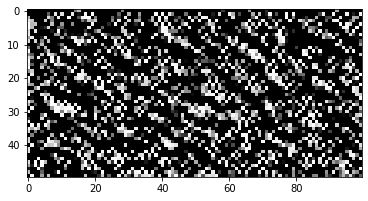

In [311]:
plt.imshow(img)